# subtitle_attribution
Subtitle attribution is the ultimate goal of this module. By using various clues in the audio, video, and subtitle streams, we were able to match onscreen characters with voices. Now we just need to go through the subtitle file and attribute each line of dialogue to the appropriate character.

In [1]:
import os
import pandas as pd
from dialogue_attribution_io import *

# Comparison with actual audio
We can compare the subtitles with the audio in a scene we've previously identified. This specific .wav file was extracted from the audio track and only contains audio from this scene. In another file, we've explored the `speaker_diarization()` function from the `pyAudioAnalysis` library to split the audio from a conversation into two clusters (corresponding to each speaker).

In [2]:
audio_file = ('../extracted_audio/prison_stereo.wav')

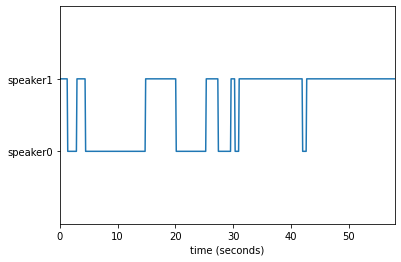

In [3]:
clusters = pyAudioAnalysis.audioSegmentation.speaker_diarization(audio_file, 2, mid_window=.8, mid_step=0.1, short_window=0.02, lda_dim=0, plot_res=True)

In [4]:
len(clusters) # 580 clusters means 58 seconds

580

# Speaker Changes
We have to work through three challenges.
1. pyAudioAnalysis' `speaker_diarization` doesn't actually tell us when someone is speaking, only the character who last spoke (whether currently speaking ot not). 
2. Frame extraction and subtitle timestamps may not line up perfectly. This is due to the issue of extracting frames from a 23.976p video.
3. Subtitles and onscreen visuals usually don't align perfectly. Subtitle authoring is more of an art than a science. They usually appear onscreen before a character actually starts speaking, but sometimes (for dramatic effect or to avoid spoiling a joke), they appear just as the character speaks.

Here are the speaker changes identified from the first 30 seconds of `speaker_diarization`. The `clusters` object contains the current or last-to-speak speaker, and reports this ten times per second. I've manually printed eight speaker changes (when the reported speaker flips from cluster 1 to 0 or 0 to 1). Remember that each item in the `clusters` list represents a tenth of a second. So a speaker change at `clusters[13]` means there's a speaker change 1.3 seconds into the scene.

In [5]:
# illustrate flip from 0 to 1 or vice versa
print('Flip A: 1.3 seconds')
for x in range(12, 14): # frame 13, or 1.3 seconds into the scene
    print(clusters[x], x)
print()
print('Flip B: 2.9 seconds')
for x in range(28, 30): # frame 29
    print(clusters[x], x)
print()
print('Flip C: 4.5 seconds')
for x in range(44, 46): # frame 45
    print(clusters[x], x)
print()
print('Flip D: 14.6 seconds')
for x in range(145, 147): # frame 146
    print(clusters[x], x)
print()
print('Flip E: 20.1 seconds')
for x in range(200, 202): # frame 201
    print(clusters[x], x)
print()
print('Flip F: 25.3 seconds')
for x in range(252, 254): # frame 253
    print(clusters[x], x)
print()
print('Flip G: 27.4 seconds')
for x in range(273, 275): # frame 274
    print(clusters[x], x)
print()
print('Flip H: 29.6 seconds')
for x in range(295, 297): # frame 296
    print(clusters[x], x)

Flip A: 1.3 seconds
1.0 12
0.0 13

Flip B: 2.9 seconds
0.0 28
1.0 29

Flip C: 4.5 seconds
0.0 44
0.0 45

Flip D: 14.6 seconds
0.0 145
0.0 146

Flip E: 20.1 seconds
1.0 200
0.0 201

Flip F: 25.3 seconds
0.0 252
1.0 253

Flip G: 27.4 seconds
1.0 273
0.0 274

Flip H: 29.6 seconds
0.0 295
1.0 296


In this example scene, I've manually looked at the .srt file and transcribed the speaker for the first 30 seconds. Since the audio file is only from this scene (and not the entire film), it start at 00:00:00; I've subtracted 00:12:46 from the subtitle times and wrote when they occur in the audio file. I've added commentary to how the 0-1 flips in `clusters` compare.

`Helen Mirren:  12:47.7-12:49.1    :01.7-:03.1` A: Flips .4 seconds early

`Jason Statham: 12:49.1-12:51.1    :03.1-:05.1` B: Flips .2 seconds early

`Helen Mirren:  12:51.1-13:00.6    :05.1-:14.6` C: Flips .6 seconds early

`Jason Statham: 13:00.6-13:02.3    :14.6-:16.3` D: Flips exactly on time

`No subtitle:   13:02.3-13:05.2    :16.3-:19.2` (Correctly) doesn't flip

`Helen Mirren:  13:05.2-13:12.1    :19.2-:26.1` E: Flips .9 seconds late

`Jason Statham: 13:12.1-13:13.7    :26.1-:27.7` F: Flips .8 seconds early

`Helen Mirren:  13:13.7-13:15.7    :27.7-:29.7` G: Flips .8 seconds early

`Simulteanous:  13:15.7-13:17.7    :29.7-:31.7` H: Flips .1 seconds early, but the subtitles here are ambigious since they contain one line of dialogue for each character.

Comparing the `clusters` from `voice_diarization()` to the actual subtitles, it looks like the clusters indicate speaker changes a little bit earlier than the subtitles. There is one exception, Flip E, which comes in .9 seconds late - this is probably because Helen Mirren's line starts with a curt and quiet "well", before continuing with the rest of her dialogue.

In [6]:
time_object = frame_to_time(766)
time_object

datetime.time(0, 12, 46)

frame_to_time + 
clusters[0] is frame time
clusters[1] is frame time + 100 milliseconds 
clusters[10] is frame time + 1 second
clusters[11] is frame time + 1 second + 100 milliseconds

In [7]:
sub_files = '../subtitles/hobbs_shaw.srt'
subs = load_subtitles(sub_files)

Must convert time object to datetime object, add time_delta, then convert back to time object

- Identify flips (need function, use memory)

- Scene start
- Add time for clusters[index] (need function that can work with identified flips)
- Add time for offset (function exists)

In [ ]:
# scene_start = datetime.time(0, 12, 47)
# convert to datetime
# timedelta for clusters[index]
# add together
# convert to time (which will eventually be used to add/subtract time offset)

In [12]:
flip_time = datetime.time(0, 12, 47, 300000)
offset_time = add_time_offset(flip_time, 400)
offset_time

datetime.time(0, 12, 47, 700000)

In [13]:
flip_time = datetime.time(0, 12, 47, 300000)
offset_time = subtract_time_offset(flip_time, 400)
offset_time

datetime.time(0, 12, 46, 900000)